# Training an Autoencoder 

As discussed in the lecture, one of the standard self-supervised learning techniques is "auto-encoding", that is 
taking a datum $x$ to a "code" $c = f_\phi(x)$ and reconstructing it again $x' = g_\theta(c)$

The training goal is to make the reconstruction as close as possible to the original: $L(x,x')$

In [1]:
import mnist
import torch
import numpy as np
import matplotlib.pyplot as plt

# Step 1

Write an Autoencoder PyTorch module that has a latent space of dimension 2

* a `encoder` submodule that is a MLP that can take `(N,28,28)` tensors and return "encoded" tensors of shape `(N,2)`
* a `decoder` submodule that is also a MLP which 

* a `forward()` method that takes a batch of MNIST images and returns a 2-tuple with 1) the encoded  values and 2)  the reconstructed images



In [2]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,2),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,28*28),
            torch.nn.Unflatten(-1,(28,28))
        )
    def forward(self,x):
        code = self.encoder(x)
        reco = self.decoder(code)
        return code,reco

# Step 2

Use `pip install mnist` to get access to the MNIST dataset and write a data-generating function
`sample_train(N, return_labels = False)` that samples N instances from the training set

optionally it should also return the labels (this is just for later, since we are doing unsupervised learning, we don't need the labels for training)

In [3]:
TRAIN = mnist.train_images()/256
TRAIN_labels = mnist.train_labels()
def sample_train(N, return_labels = False):
    idxs = np.random.choice(np.arange(len(TRAIN)), size = N) 
    images = TRAIN[idxs]
    labels = TRAIN_labels[idxs]
    if return_labels:
        return torch.FloatTensor(images), torch.FloatTensor(labels)
    return torch.FloatTensor(images)

# Step 3

Write a training loop with your Autoencoder model that trains using mini-batches of size 200 and using a standard mean-squared-error (MSE) loss. Train for 50k steps with learning rate 1e-3 (with Adam)

**Optionally**: it's nice to track how the autoencoder is doing as you train.

Write a plotting function `plot(model,samples)` that takes a mini batch of size 1 and plots both the original as well as the reconstructed images side by side

0 0.11999065428972244


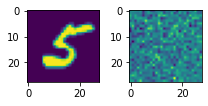

1000 0.04308487847447395
2000 0.041289590299129486
3000 0.03984299674630165
4000 0.038299884647130966
5000 0.03700817748904228
6000 0.03910040482878685
7000 0.03551292419433594
8000 0.03585313260555267
9000 0.036626171320676804
10000 0.03432125598192215


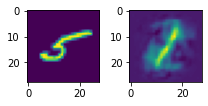

11000 0.04181649163365364
12000 0.035550810396671295
13000 0.03759386017918587
14000 0.03440221771597862
15000 0.03539612516760826
16000 0.03534528985619545
17000 0.03434555232524872
18000 0.03497949615120888
19000 0.03542933240532875
20000 0.03679703548550606


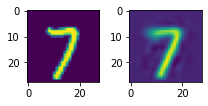

21000 0.03458843007683754
22000 0.03622521832585335
23000 0.0368732213973999
24000 0.03337420895695686
25000 0.03441056236624718
26000 0.035132259130477905
27000 0.03537941724061966
28000 0.03518855199217796
29000 0.03291909024119377
30000 0.03402625396847725


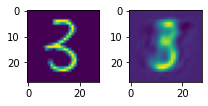

31000 0.03465970233082771
32000 0.032418422400951385
33000 0.03676298260688782
34000 0.034319669008255005
35000 0.0334344245493412
36000 0.03576410189270973
37000 0.03269755840301514
38000 0.03476470336318016
39000 0.03502022102475166
40000 0.032729435712099075


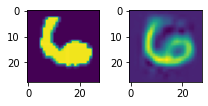

41000 0.03578994423151016
42000 0.036315351724624634
43000 0.032633714377880096
44000 0.03499223664402962
45000 0.03599545359611511
46000 0.034776460379362106
47000 0.03297163173556328
48000 0.036144934594631195
49000 0.033750180155038834


In [4]:
def plot(model,sample):
    f,axarr = plt.subplots(1,2)
    with torch.no_grad():
        code,reco = model(sample)
    axarr[0].imshow(sample[0])
    axarr[1].imshow(reco[0])
    f.set_tight_layout(True)


def train():
    model = Autoencoder()
    opt = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(50000):
        x = sample_train(200)
        code,reco = model(x)
        loss = torch.nn.functional.mse_loss(x,reco)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 1000 == 0:
            print(i,float(loss))
        if i % 10000 == 0:
            plot(model,sample_train(1))
            plt.gcf().set_size_inches(3,3)
            plt.show()
    return model
m = train()

# Step 4: Exploring the Latent Space

Sample a mini batch of size 10,000 **with** labels and encode it into the latent space with the
trained encoder. Since it's a 2-D latent space we can easily visualize it. Plot the distribution
of codes as a scatter plot in the $(c_1,c_2)$-plane and color the markers according to the true label

Observe how the individual clusters correspond among other things to the label

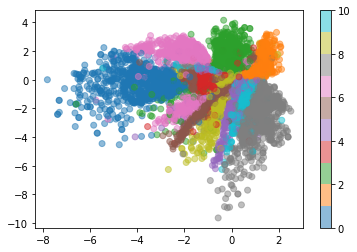

In [5]:
def plot_latent_space(model):
    x,y = sample_train(10000, return_labels = True)
    with torch.no_grad():
        codes,reco = model(torch.FloatTensor(x))
    plt.scatter(codes[:,0],codes[:,1],c = y,cmap = 'tab10', alpha = 0.5, vmin = 0, vmax = 10)
    plt.colorbar()
    
plot_latent_space(m)

# Step 5: Generating new images

Given the distribution in the latent space you should have a good feel, which type of code, 
corresponds to which digit.

* Try to take a code that you think would generate a 4

As you see, the distribution in the latetn space is a bit unruly, if you would

* Generate a digit based on a random R^2 value

you would have a hard time recognizing it as a digit. Try it!

To fix this, we discussed in the lecture the idea of a "Variational Autoencoder" that tries
to control the latent distribution


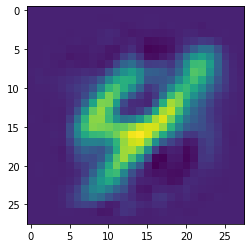

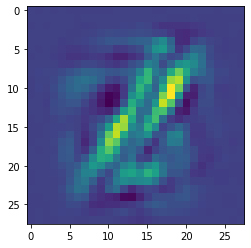

In [6]:
plt.imshow(m.decoder(torch.FloatTensor([[-0.5,-4]])).detach()[0])
plt.show()
plt.imshow(m.decoder(torch.FloatTensor([[5,5]])).detach()[0])
plt.show()